## Transfer Learning with TensorFlow Part 1: Feautre Extraction

Transfer learning is leverging a working model's existing architecture and learned patterns for our own.

There are two main benifits:
1. Can leverage an existing neural netwok architecture proven to work on similar to our own.
2. Can leverage a working neural netwok architecure which has already learned patterns on similar data on our own, then we can adapt those patterns to our own data.

## Downloading and become one with data 

In [16]:
# Get data (10 % of 10 food classes of food1o1)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-10 17:50:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  48.4MB/s    in 3.3s    

2022-02-10 17:50:43 (48.4 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [17]:
# How many images in each folder?
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

## Creating data loaders (preparing the data)

we'll use the `ImageDataGenerator` class to load in our images in batches.

In [18]:
# Setup a data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your model to be perfomed during or after training. Some of the most popular callbacks:
* Tracking experiment with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from trainig (before it trains too long and overfits) with the EarlyStoppind callback

In [19]:
import tensorflow as tf

In [20]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}") 
  return tensorboard_callback

**Note:** You can customize the directory where your tensorboard logs(model training metrics) get saved to whatever you like . The `log_dir` parameter we've created above is only one option.

## Creating model using TensorFlow Hub

Im the past we've used TensorFlow to create our own model layer from scratch.
Now we're going to do a similar process, except the majority of our model layers are going to come from TensorFlow Hub.
We can access pretrained model on: https://tfhub.dev/

Browsing the tensorflow hub page and soring for image classification , we found the following feature vector model link:  https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [21]:
# Let's compare the two following model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [22]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [23]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [24]:
# Let's make create_model() function to creatr a model from a URL
def create_model(model_url, num_classes=10):
  """
  Take a TensorFlow Hub and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub Feature Extraction URL.
    num_classes (int): Number of output neurons in output layer, 
     should be equal to number of target classes default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor 
  layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation="softmax", name="output_layer")                          
  ])

  return model



## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [25]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [32]:
# Compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [33]:
# Let's fit our ResNet model to data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220210-175734
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.8356 - accuracy: 0.3960 - val_loss: 1.1963 - val_accuracy: 0.6136
Epoch 2/5
24/24 [==============================] - 22s 932ms/step - loss: 0.8879 - accuracy: 0.7293 - val_loss: 0.8554 - val_accuracy: 0.7212
Epoch 3/5
24/24 [==============================] - 22s 925ms/step - loss: 0.6047 - accuracy: 0.8387 - val_loss: 0.7444 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 22s 925ms/step - loss: 0.4615 - accuracy: 0.8840 - val_loss: 0.7099 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 21s 918ms/step - loss: 0.3659 - accuracy: 0.9227 - val_loss: 0.6877 - val_accuracy: 0.7800


Wow!

That.is.incredible. our tranfer learning feature extractor model out performed ALL of the previous model we built by hand...(substantially) and in quicker training time AND even with 10% of training example.

In [34]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like these into script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seprate loss curves for trainig and validation metrics.

  Args:
    history = TensorFlow History Object

  Results:
    Plot of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();
 


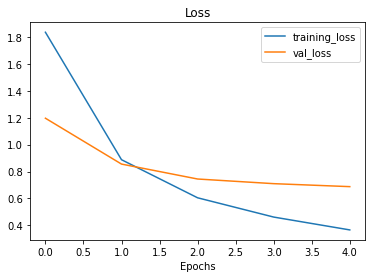

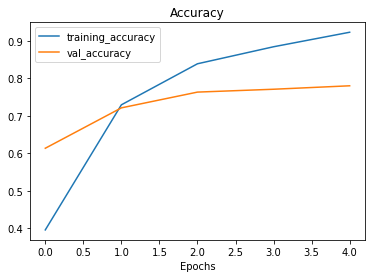

In [35]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [36]:
# Create EfficientNetB0 featre extractor model- details on Effiecientnet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model =create_model(model_url=efficientnet_url,
                                 num_classes=train_data_10_percent.num_classes)

# Compile Efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the Efficientnet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientb0/20220210-184245
Epoch 1/5
24/24 [==============================] - 34s 954ms/step - loss: 1.8411 - accuracy: 0.4547 - val_loss: 1.2843 - val_accuracy: 0.7556
Epoch 2/5
24/24 [==============================] - 19s 814ms/step - loss: 1.0534 - accuracy: 0.7920 - val_loss: 0.8543 - val_accuracy: 0.8336
Epoch 3/5
24/24 [==============================] - 19s 810ms/step - loss: 0.7462 - accuracy: 0.8427 - val_loss: 0.6861 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 19s 834ms/step - loss: 0.5996 - accuracy: 0.8747 - val_loss: 0.6005 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 19s 813ms/step - loss: 0.5070 - accuracy: 0.8920 - val_loss: 0.5478 - val_accuracy: 0.8712


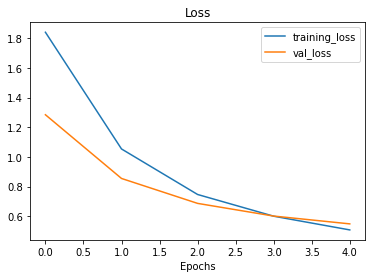

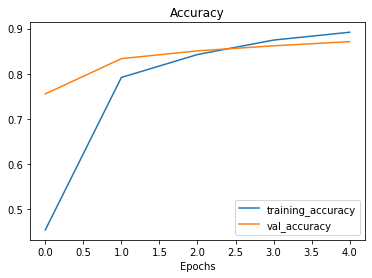

In [37]:
plot_loss_curves(efficientnet_history)

In [38]:
# How many layers does our efficientnet feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction"** transfer learning - use the prelearned patterns of an existing model(e.g. EfficientnetB0 trained on ImageNet)  and adjust the output layer for your own problem(e.g. 1000 classes -> 10 classes of food)
* **"Fine tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers) 


## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're runing private experiments (things you do not want other to see) do not upload them to TensorBoard.dev. 

In [ ]:
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "comparing two different TF Hub feature extraction model architecures using 10% of the training data" \
  --one_shot

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/SENB4NrLQjKfmMl0E3SwWA/

In [41]:
# Checkout what tesorboard experiments you have?
!tensorboard dev list

https://tensorboard.dev/experiment/SENB4NrLQjKfmMl0E3SwWA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          comparing two different TF Hub feature extraction model architecures using 10% of the training data
	Id                   SENB4NrLQjKfmMl0E3SwWA
	Created              2022-02-10 19:34:18 (8 minutes ago)
	Updated              2022-02-10 19:34:21 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5921532
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id SENB4NrLQjKfmMl0E3SwWA  

In [42]:
# confirm the deletion by re-checking what experiments you have?
!tensorboard dev list

https://tensorboard.dev/experiment/SENB4NrLQjKfmMl0E3SwWA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          comparing two different TF Hub feature extraction model architecures using 10% of the training data
	Id                   SENB4NrLQjKfmMl0E3SwWA
	Created              2022-02-10 19:34:18 (12 minutes ago)
	Updated              2022-02-10 19:34:21 (12 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5921532
Total: 1 experiment(s)
